<a href="https://colab.research.google.com/github/shramkoartem/HackerRank/blob/master/notebooks/GAN_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# First NN with PyTorch
p.30

In [ ]:
# download mnist dataset

!wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2021-01-28 08:49:14--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M   509KB/s    in 3m 22s  

2021-01-28 08:52:36 (530 KB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2021-01-28 08:52:36--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M   369KB/s    in 51s     

2021-01-28 08:53:27 (348 KB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [ ]:
# from google.colab import drive
# drive.mount("./mount")

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
# io
df = pd.read_csv("mnist_train.csv", header=None)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60000 entries, 0 to 59999
Columns: 785 entries, 0 to 784
dtypes: int64(785)
memory usage: 359.3 MB


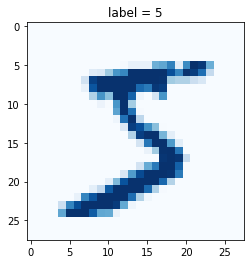

In [ ]:
# visualizing data sample

# select a sample
row = 0
data = df.iloc[row]

# label is the first value
label = data[0]

# image data is the remaining 784 values
image = data[1:].values.reshape(28,28)
plt.title("label = " + str(label))
plt.imshow(image, interpolation="none", cmap="Blues")
plt.show()

## Simple Network

In [ ]:
# torch imports

import torch
import torch.nn as nn

from torch.utils.data import Dataset

In [ ]:
class Classifier(nn.Module):
  
  # constructor __init__ called upon object creation
  def __init__(self):
    # initialize parent pytorch class (parents constructor)
    super().__init__()
    
    self.model = nn.Sequential(
        nn.Linear(784,200), # contains weights
        nn.Sigmoid(), # logistic activation function
        nn.Linear(200,10), # "Linear" because f(x) = w*x + b
        nn.Sigmoid()
    )

    self.loss_function = nn.MSELoss()
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # visualizing training progress
    self.counter = 0
    self.progress = []



  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    # foward pass
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # zero gradients
    self.optimizer.zero_grad()

    # calculate gradients
    loss.backward()

    # update weights
    self.optimizer.step() # literally take a step down the grads

    # visualizing progress
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
  
    if (self.counter % 1000 == 0):
      print(f"Iter: {self.counter:10}, Loss: {loss:10.6f}")



  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=["loss"])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker=".",
            grid=True, yticks=(0, 0.25, 0.5))
    pass


Just like we inherit a neural network class from nn.Module and provide a `forward()` function, for  a dataset we inherit from Dataset and provide the following two special functions:  
- `__len__()` which returns the number of items in the dataset.  
- `__getitem__()` which returns the nth item in the dataset. 



In [ ]:
class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.data_df = pd.read_csv(csv_file, header = None)
    pass

  def __len__(self):
    return len(self.data_df)

  def __getitem__(self, idx):

    # target
    label = self.data_df.iloc[idx, 0]
    target = torch.zeros((10))
    target[label] = 1.0

    # image data, normalized from 0-255 to 0-1
    image_values = torch.FloatTensor(self.data_df.iloc[idx,1:].values) / 255.0

    return label, image_values, target

  def plot_image(self, idx):
    arr = self.data_df.iloc[idx,1:].values.reshape(28,28)
    plt.title("label = " + str(self.data_df.iloc[idx,0]))
    plt.imshow(arr, interpolation='none', cmap="Blues")
    pass

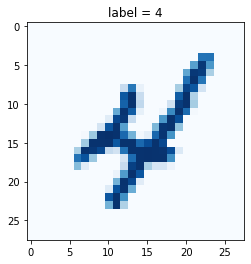

In [ ]:
mnist_dataset = MnistDataset("mnist_train.csv")
mnist_dataset.plot_image(9)

In [ ]:
%%time

# training network
model = Classifier()

epochs = 3

def train(model, epochs):
  for i in range(epochs):
    print("training epoch", i+1, "of", epochs)

    for label, image_data_tensor, target_tensor in mnist_dataset:
      model.train(image_data_tensor, target_tensor)

  return model

# train(model, epochs)

CPU times: user 3.09 ms, sys: 13 µs, total: 3.1 ms
Wall time: 5.59 ms


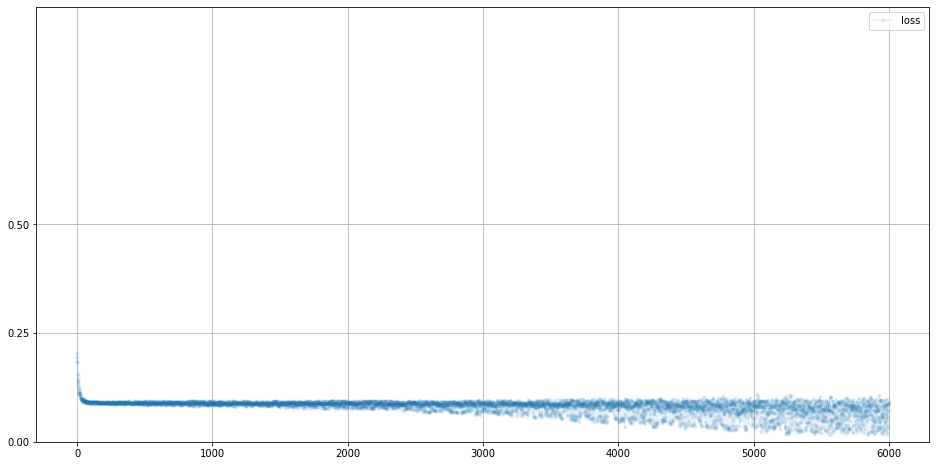

In [ ]:
model.plot_progress()

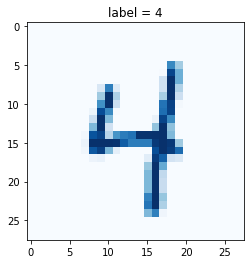

In [ ]:
# test performance

mnist_test_dataset = MnistDataset("mnist_test.csv")

record = 19

mnist_test_dataset.plot_image(record)

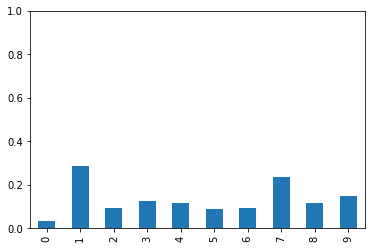

In [ ]:
image_data = mnist_dataset[record][1]

# query the trained network
output = model.forward(image_data)

pd.DataFrame(output.detach().numpy()).plot(kind="bar", legend=False, ylim=(0,1))

In [ ]:
# test model on test data

mnist_test_dataset = MnistDataset("mnist_test.csv")

score = 0
items = 0

for label, image_data_tensor, target_tensor in mnist_test_dataset:
  answer = model.forward(image_data_tensor).detach().numpy()
  if answer.argmax == label:
    score += 1

  items +=1

print(score, items, score/items)

0 10000 0.0


# Refinements

## Loss Function

For the second task, a classification task, a different kind of loss function makes more sense.  A popular one is called the Binary Cross Entropy loss, and it tries to penalise wrong but  confident outputs as well as correct but not so confident outputs. PyTorch provides this as  `nn.BCELoss(). `


In [ ]:
class Classifier(nn.Module):
  
  # constructor __init__ called upon object creation
  def __init__(self):
    # initialize parent pytorch class (parents constructor)
    super().__init__()
    
    self.model = nn.Sequential(
        nn.Linear(784,200), # contains weights
        nn.Sigmoid(), # logistic activation function
        nn.Linear(200,10), # "Linear" because f(x) = w*x + b
        nn.Sigmoid()
    )

    self.loss_function = nn.BCELoss()
    self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # visualizing training progress
    self.counter = 0
    self.progress = []



  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    # foward pass
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # zero gradients
    self.optimizer.zero_grad()

    # calculate gradients
    loss.backward()

    # update weights
    self.optimizer.step() # literally take a step down the grads

    # visualizing progress
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
  
    if (self.counter % 1000 == 0):
      print(f"Iter: {self.counter:10}, Loss: {loss:10.6f}")



  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=["loss"])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker=".",
            grid=True, yticks=(0, 0.25, 0.5))
    pass


In [ ]:
model = Classifier()

model = train(model, epochs=3)

training epoch 1 of 3
counter = 1000
loss = 0.3282
counter = 2000
loss = 0.3090
counter = 3000
loss = 0.3250
counter = 4000
loss = 0.2930
counter = 5000
loss = 0.3351
counter = 6000
loss = 0.2956
counter = 7000
loss = 0.3080
counter = 8000
loss = 0.3112
counter = 9000
loss = 0.3291
counter = 10000
loss = 0.2586
counter = 11000
loss = 0.2636
counter = 12000
loss = 0.2842
counter = 13000
loss = 0.3006
counter = 14000
loss = 0.2632
counter = 15000
loss = 0.2477
counter = 16000
loss = 0.1643
counter = 17000
loss = 0.2262
counter = 18000
loss = 0.2657
counter = 19000
loss = 0.2300
counter = 20000
loss = 0.2050
counter = 21000
loss = 0.2308
counter = 22000
loss = 0.1534
counter = 23000
loss = 0.1557
counter = 24000
loss = 0.1581
counter = 25000
loss = 0.1988
counter = 26000
loss = 0.0889
counter = 27000
loss = 0.0943
counter = 28000
loss = 0.1403
counter = 29000
loss = 0.1667
counter = 30000
loss = 0.1851
counter = 31000
loss = 0.1956
counter = 32000
loss = 0.2187
counter = 33000
loss = 0.07

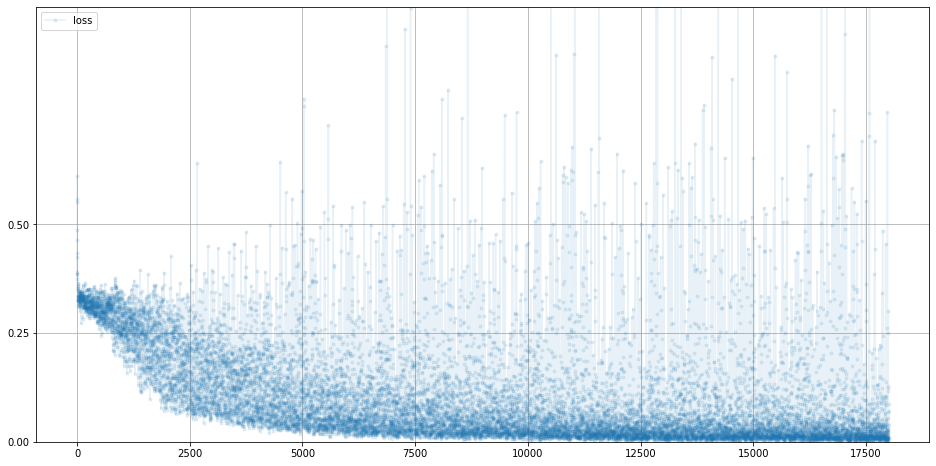

In [ ]:
model.plot_progress()

In [ ]:
# test model on test data

mnist_test_dataset = MnistDataset("mnist_test.csv")

def eval():

  score = 0
  items = 0
  for label, image_data_tensor, target_tensor in mnist_test_dataset:
    answer = model.forward(image_data_tensor).detach().numpy()
    if answer.argmax() == label:
      score += 1

    items +=1

  print(score, items, score/items)

In [ ]:
eval()

## Activation function

Sigmoid suffers wanishing gradient problem for large (close to 1) or low( close to -1) values. 

ReLU allows to forgo that. 
LeakyRelu has a non zero gradients for values < 0, so we use it instead

## Optimisation

A weakness with the simple stochastic gradient descent is that it can get stuck in local minima in  the loss function. Another weakness is that a single learning rate applies to all learnable  parameters. 

There are several popular alternatives, and a notable one is called Adam. It addresses the two  challenges directly. It uses the idea of a momentum to reduce the chances of getting stuck in a  local minimum, a bit like how a heavy ball can roll through a small pothole because its  momentum carries it through. It also uses a separate learning rate for each learnable  parameter, which can adapt to how each parameter changes during training. 



In [ ]:
class Classifier(nn.Module):
  
  # constructor __init__ called upon object creation
  def __init__(self):
    # initialize parent pytorch class (parents constructor)
    super().__init__()


    #######################
    #         NEW.        #
    #######################

    # changing activation function has significant effect 
    # due to better gradients
    self.model = nn.Sequential(
        nn.Linear(784,200), # contains weights
        nn.LeakyReLU(0.02), # tackles the wanishing gradient descent problem

        nn.LayerNorm(200),  # normalization

        nn.Linear(200,10), # "Linear" because f(x) = w*x + b
        nn.Sigmoid()
    )

    self.loss_function = nn.MSELoss()

    
    #######################
    #         NEW.        #
    #######################
    # Adamax uses momentum when calculating descents
    self.optimizer = torch.optim.Adam(self.parameters())
    #self.optimizer = torch.optim.SGD(self.parameters(), lr=0.01)

    # visualizing training progress
    self.counter = 0
    self.progress = []



  def forward(self, inputs):
    return self.model(inputs)

  def train(self, inputs, targets):
    # foward pass
    outputs = self.forward(inputs)

    # calculate loss
    loss = self.loss_function(outputs, targets)

    # zero gradients
    self.optimizer.zero_grad()

    # calculate gradients
    loss.backward()

    # update weights
    self.optimizer.step() # literally take a step down the grads

    # visualizing progress
    self.counter += 1
    if (self.counter % 10 == 0):
      self.progress.append(loss.item())
      pass
  
    if (self.counter % 10000 == 0):
      print(f"Iter: {self.counter:10}, Loss: {loss:10.6f}")


  def plot_progress(self):
    df = pd.DataFrame(self.progress, columns=["loss"])
    df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker=".",
            grid=True, yticks=(0, 0.25, 0.5))
    pass


training epoch 1 of 3
counter = 1000
loss = 0.0011
counter = 2000
loss = 0.0002
counter = 3000
loss = 0.0061
counter = 4000
loss = 0.0001
counter = 5000
loss = 0.0008
counter = 6000
loss = 0.0001
counter = 7000
loss = 0.0016
counter = 8000
loss = 0.0005
counter = 9000
loss = 0.0004
counter = 10000
loss = 0.0002
counter = 11000
loss = 0.0000
counter = 12000
loss = 0.0025
counter = 13000
loss = 0.0003
counter = 14000
loss = 0.0000
counter = 15000
loss = 0.0897
counter = 16000
loss = 0.0003
counter = 17000
loss = 0.0001
counter = 18000
loss = 0.0000
counter = 19000
loss = 0.0000
counter = 20000
loss = 0.0000
counter = 21000
loss = 0.0933
counter = 22000
loss = 0.0000
counter = 23000
loss = 0.0000
counter = 24000
loss = 0.0219
counter = 25000
loss = 0.0000
counter = 26000
loss = 0.0000
counter = 27000
loss = 0.0030
counter = 28000
loss = 0.0000
counter = 29000
loss = 0.0000
counter = 30000
loss = 0.0012
counter = 31000
loss = 0.0000
counter = 32000
loss = 0.0009
counter = 33000
loss = 0.00

UnboundLocalError: ignored

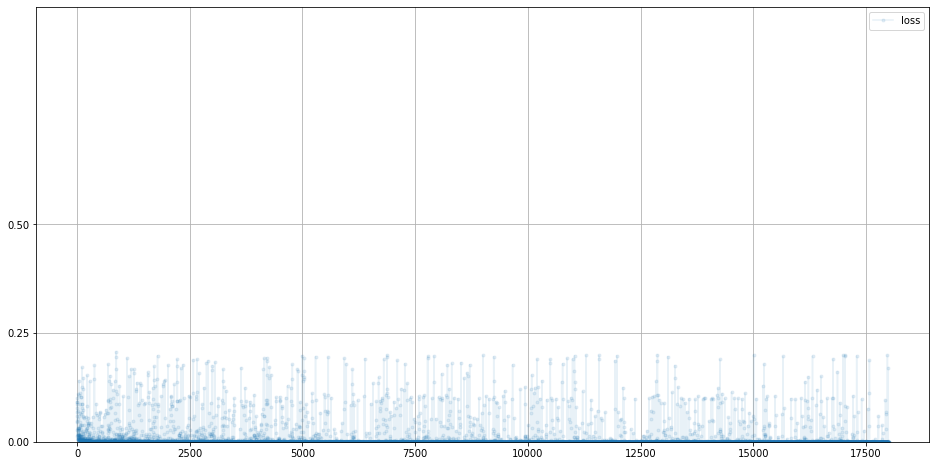

In [ ]:
model = Classifier()

model = train(model, 3)

model.plot_progress()

eval()

In [ ]:
eval()

9671 10000 0.9671


# Takeaways 


- The mean squared error loss is suited to regression tasks where the output can be in  a continuous range. The binary cross entropy loss is better suited to classification  tasks where the output should be 1 or 0, for true and false.  

- The traditional sigmoid activation function suffers from vanishing gradients for large  input values. This leads to poor feedback signals for training a network. The ReLU  activation function solves this by having good gradients for positive inputs. The  LeakyReLU improves this by also having a small non-vanishing gradient for negative  values.  

- The Adam optimiser uses momentum to overcome local minima, and maintains  individual learning rates for each learnable parameter. For many tasks it performs  better than the simple SGD optimiser.  

- Normalisation can stabilise the training of neural networks. It is common to normalise  a network’s initial weights. Normalising signal values


# CUDA

In [ ]:
# standard code to utilize CUDA

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print(f"using CUDA: {torch.cuda.get_device_name()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cpu')

# Part 2 - GAN



- Let’s reward the generator when it gets an image past the discriminator.  
- Let’s punish the generator when it gets caught as an image forger.  

Trying not to think too much about the loss function, let’s take a step back and look at the whole  picture.  

The discriminator’s job is to separate the real images from the generated ones. If the generator  is not very good, this job will be easy. But if we train the generator, then it should get better and  better at generating images that look more and more like real images.  

That’s pretty cool. But there’s more.  

As the discriminator gets better and better with training, the generator must also get better and  better if it is to get past an ever more capable discriminator. Eventually, the generator should get  really good at creating images that are indistinguishable from real images.  

The discriminator and generator are set to compete against each other as adversaries, each  trying to outdo the other, and in the process, both getting better and better. This architecture is  called a Generative Adversarial Network, or GAN.  

It’s a clever architecture, not just because it uses competition to drive improvement, but also  because we don’t need to define detailed rules that describe a real image to be encoded into  the loss function.



# Simple 1010 pattern

In [ ]:
  import torch
  import torch.nn as nn

  import pandas as pd
  import matplotlib.pyplot as np

  import random

In [ ]:
class Discriminator(nn.Module):

  # constructor
  def __init__(self):

    # instantiate parent pytorch class
    super().__init__()

    self.model = nn.Sequential(
         nn.Linear(4,3),
         nn.Sigmoid(),
         nn.Linear(3,1),
         nn.Sigmoid()
    )

  def forward(self, inputs):
    return self.model(inputs)



In [ ]:
def train_discriminator(model, generators, criterion, optimizer, epochs):

  counter = 0
  progress = []

  for epoch in range(epochs):

      for source in ["real", "fake"]:

        inputs = generators[source]["generator"]()
        target = generators[source]["target"]

        output = model(inputs)

        loss = criterion(output, target)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

      counter += 1
      if counter % 10 == 0:
        progress.append(loss.item())

      if counter % 1000 == 0:
        print(f"iter: {counter:10}, loss: {loss.item():10.6f}")

  return model, progress

In [ ]:
def plot_progress(progress):
  df = pd.DataFrame(progress, columns=["loss"])
  df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker=".",
          grid=True, yticks=(0, 0.25, 0.5))
  


### Test discriminator with random data

In [ ]:
# test descriminator

def generate_random(size=4):
  return torch.rand(size)

test = generate_random()

discriminator(test)

tensor([0.4450], grad_fn=<SigmoidBackward>)

In [ ]:
# real data source
# always generates 1010 pattern with slight randomness

def generate_real():
  real_data = torch.FloatTensor(
      [random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2),
       random.uniform(0.8, 1.0),
       random.uniform(0.0, 0.2)
      ])
  return real_data

generate_real()

tensor([0.9102, 0.1362, 0.8429, 0.0520])

In [ ]:
discriminator = Discriminator()

criterion = nn.MSELoss()

optim = torch.optim.SGD(discriminator.parameters(), lr=0.01)

generators = {"real" : {"generator" : generate_real,
                        "target" : torch.tensor(1, dtype=torch.float)},
              "fake" : {"generator" : generate_random,
                        "target" : torch.tensor(0, dtype=torch.float)}
              }

train_params = {
    "model" : discriminator,
    "generators" : generators,
    "criterion" : criterion,
    "optimizer" : optim,
    "epochs" : 10000

}

In [ ]:
d, history = train_discriminator(**train_params)

/usr/local/lib/python3.6/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


iter:       1000, loss:   0.233689
iter:       2000, loss:   0.251637
iter:       3000, loss:   0.178252
iter:       4000, loss:   0.085861
iter:       5000, loss:   0.047325
iter:       6000, loss:   0.050655
iter:       7000, loss:   0.094293
iter:       8000, loss:   0.150659
iter:       9000, loss:   0.048743
iter:      10000, loss:   0.096914


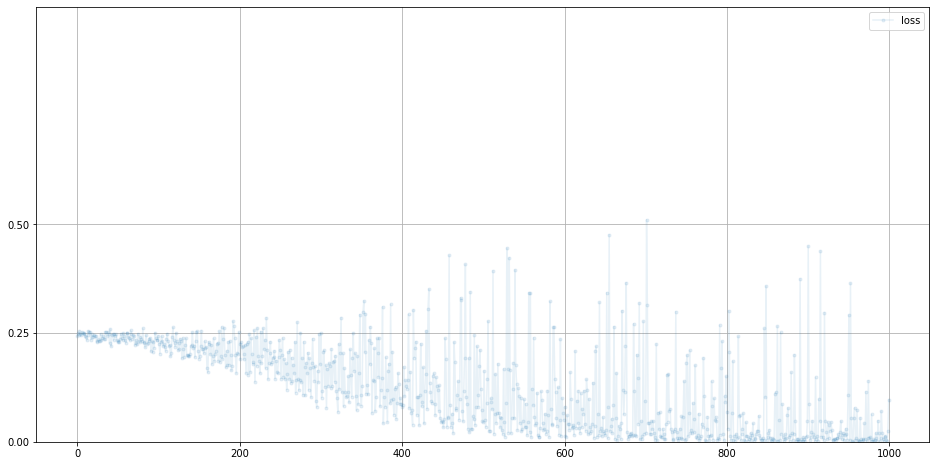

In [ ]:
plot_progress(history)

In [ ]:
d(generate_real())

tensor([0.8131], grad_fn=<SigmoidBackward>)

In [ ]:
d(generate_random())

tensor([0.0771], grad_fn=<SigmoidBackward>)

# Building the generator

In [ ]:
torch.linspace(0,1,10)

tensor([0.0000, 0.1111, 0.2222, 0.3333, 0.4444, 0.5556, 0.6667, 0.7778, 0.8889,
        1.0000])

In [ ]:
class Generator(nn.Module):
  """ Generates 1010 pattern """

  # generator doesnt need its own loss function
  # parameters of the generator are updated based
  # on the loss function that is applied to the 
  # outputs of the discriminator

  # constructor
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(1,3),
        nn.Sigmoid(),
        nn.Linear(3,4),
        nn.Sigmoid()
    )


  def forward(self, inputs):
    # forward pass
    return self.model(inputs)

In [ ]:
# redefining our training loop

def train(discriminator, generator, criterion, d_optimizer, g_optimizer, epochs):

  counter = 0
  d_progress = []
  g_progress = []

  for epoch in range(epochs):

    # STEP 1: train descriminator on real
    #######################################
    inputs = generate_real()
    d_output = discriminator(inputs)

    # loss function: target = 1
    loss = criterion(d_output, torch.FloatTensor([1.0]))

    # discriminator optimizer
    # zero_grad, backprop, optim
    d_optimizer.zero_grad()
    loss.backward()
    d_optimizer.step()

    # STEP 2: train discriminator on false
    #######################################
    g_output = generator(torch.FloatTensor([0.5])) # we take 0.5 as noise input
    # use detach(), so gradients in generator are not computed
    d_output = discriminator(g_output.detach())

    # loss function: target = 0
    loss = criterion(d_output, torch.FloatTensor([0.0]))

    # discriminator optimizer
    # zero grad, backprop, optim
    d_optimizer.zero_grad()
    loss.backward()
    d_optimizer.step()

    if counter % 10 == 0:
      d_progress.append(loss.item())

    # STEP 3: train generator
    #######################################
    # generate pattern from noise
    g_output = generator(torch.FloatTensor([0.5]))

    # pass it to discriminator
    d_output = discriminator(g_output)

    # calculate error
    loss = criterion(d_output, torch.FloatTensor([1.0]))

    # generator optimizer
    # zero grad, backprop, optim
    g_optimizer.zero_grad()
    loss.backward()
    g_optimizer.step()

    counter += 1
    if counter % 10 == 0:
      g_progress.append(loss.item())

    if counter % 1000 == 0:
      print(f"iter: {counter:6}, loss dis: {d_progress[-1]:10.6f}, loss gen: {g_progress[-1]:10.6f}")

  return discriminator, generator, d_progress, g_progress


In [ ]:
D = Discriminator()
G = Generator()

criterion = nn.MSELoss()

d_optimizer = torch.optim.SGD(D.parameters(), lr=0.01)
g_optimizer = torch.optim.SGD(G.parameters(), lr=0.01)

epochs = 10000

params = {
    "discriminator" : D,
    "generator" : G,
    "criterion" : criterion,
    "d_optimizer" : d_optimizer,
    "g_optimizer" : g_optimizer,
    "epochs" : epochs
}

In [ ]:
discriminator, generator, d_progress, g_progress = train(**params)

iter:   1000, loss dis:   0.253058, loss gen:   0.248264
iter:   2000, loss dis:   0.244610, loss gen:   0.256712
iter:   3000, loss dis:   0.230385, loss gen:   0.271828
iter:   4000, loss dis:   0.209463, loss gen:   0.295673
iter:   5000, loss dis:   0.203404, loss gen:   0.302919
iter:   6000, loss dis:   0.222317, loss gen:   0.280893
iter:   7000, loss dis:   0.242526, loss gen:   0.259384
iter:   8000, loss dis:   0.253910, loss gen:   0.247934
iter:   9000, loss dis:   0.261761, loss gen:   0.240109
iter:  10000, loss dis:   0.264353, loss gen:   0.237818


In [ ]:
test = generator(torch.FloatTensor([0.5]))
test

tensor([0.9426, 0.0453, 0.9324, 0.0581], grad_fn=<SigmoidBackward>)

In [ ]:
discriminator(generate_random())

tensor([0.1874], grad_fn=<SigmoidBackward>)

- A good pattern for developing and training a GAN includes the following steps. (1)  preview data from the real dataset, (2) test the discriminator can at least learn to  separate real data from random noise, (3) test the untrained generator can create  data of the right shape, (4) visualise the loss values to understand how well training  progressed.  

- A successfully trained GAN has a discriminator that can’t tell real from generated data.  Its output is 0.5, half way between 0.0 and 1.0. The ideal mean squared error loss is  0.25.  

- It can be useful to separately visualise the discriminator and generator loss. The  generator loss is the loss at the discriminator caused by a generated data example. 



# Handwritten Digits

In [1]:
# download mnist dataset

!wget https://pjreddie.com/media/files/mnist_train.csv
!wget https://pjreddie.com/media/files/mnist_test.csv

--2021-01-29 10:09:13--  https://pjreddie.com/media/files/mnist_train.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109575994 (104M) [application/octet-stream]
Saving to: ‘mnist_train.csv’

mnist_train.csv     100%[===================>] 104.50M   193KB/s    in 8m 59s  

2021-01-29 10:18:13 (199 KB/s) - ‘mnist_train.csv’ saved [109575994/109575994]

--2021-01-29 10:18:13--  https://pjreddie.com/media/files/mnist_test.csv
Resolving pjreddie.com (pjreddie.com)... 128.208.4.108
Connecting to pjreddie.com (pjreddie.com)|128.208.4.108|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 18289443 (17M) [application/octet-stream]
Saving to: ‘mnist_test.csv’

mnist_test.csv      100%[===================>]  17.44M   209KB/s    in 90s     

2021-01-29 10:19:43 (199 KB/s) - ‘mnist_test.csv’ saved [18289443/18289443]



In [2]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset 

import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt


In [43]:
# standard code to utilize CUDA

if torch.cuda.is_available():
  torch.set_default_tensor_type(torch.cuda.FloatTensor)
  print(f"using CUDA: {torch.cuda.get_device_name()}")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

using CUDA: Tesla T4


device(type='cuda')

In [3]:
# Mnist dataset

class MnistDataset(Dataset):

  def __init__(self, csv_file):
    self.dataset = pd.read_csv(csv_file, header=None)

  def __len__(self):
    return self.len(dataset)

  def __getitem__(self, idx):
    # target
    label = self.dataset.iloc[idx,0]
    target = torch.zeros((10))
    target[label] = 1.0


    image = self.dataset.iloc[idx,1:].values / 255.0
    #image = image.reshape((28,28))
    image = torch.tensor(image, dtype=torch.float)

    return label, image, target

  def plot_image(self, idx):
    arr = self.dataset.iloc[idx,1:].values.reshape(28,28)
    plt.title(f"label = {self.dataset.iloc[idx,0]}")
    plt.imshow(arr, interpolation="none", cmap="Blues")

In [4]:
train_ds = MnistDataset("mnist_train.csv")

In [71]:
# Discriminator

class Discriminator(nn.Module):

  # constructor
  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(784,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200, 1),
        nn.Sigmoid()
    )

  # forward pass
  def forward(self, inputs):
    return self.model(inputs)

In [6]:
D = Discriminator()


sample = next(iter(train_ds))
D(sample[1])

tensor([0.5895], grad_fn=<SigmoidBackward>)

In [38]:
def train_discriminator(model, criterion, optimizer, epochs):
  
  counter = 0
  progress = []

  for epoch in range(epochs):
    for label, image, targets in train_ds:

      # show real
      image = image.to(device)
      outputs = model(image).to(device)

      real = torch.tensor([1.0], dtype = torch.float, device=device)
      loss = criterion(outputs, real)

      # zero grad, backward prop, calculate gradients
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # show fake
      inputs = torch.rand(image.size(), device = device)
      outputs = model(inputs).to(device)

      fake = torch.tensor([0.0], dtype = torch.float, device=device)
      loss = criterion(outputs, fake)

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      # statistics
      counter+=1
      if counter % 10 ==0:
        progress.append(loss.item())

      if counter % 1000 ==0:
        print(f"iter: {counter:8}, loss: {progress[-1]:8.6f}")


    return model, progress

In [8]:
def plot_progress(progress):
  df = pd.DataFrame(progress, columns=["loss"])
  df.plot(ylim=(0,1.0), figsize=(16,8), alpha=0.1, marker=".",
          grid=True, yticks=(0, 0.25, 0.5))

In [33]:
D = Discriminator()
D = D.to(device)

criterion = nn.MSELoss()

optim = torch.optim.SGD(D.parameters(), lr=0.001)

epochs = 1

device = "cuda:0" if torch.cuda.is_available() else "cpu"

params = {"model" : D,
          "criterion" : criterion,
          "optimizer" : optim,
          "epochs" : epochs}

In [39]:
%%time

model, progress = train_discriminator(**params)

iter:     1000, loss: 0.000351
iter:     2000, loss: 0.000095
iter:     3000, loss: 0.000020
iter:     4000, loss: 0.000064
iter:     5000, loss: 0.000038
iter:     6000, loss: 0.000074
iter:     7000, loss: 0.000083
iter:     8000, loss: 0.000076
iter:     9000, loss: 0.000043
iter:    10000, loss: 0.000362
iter:    11000, loss: 0.000024
iter:    12000, loss: 0.000039
iter:    13000, loss: 0.000050
iter:    14000, loss: 0.000028
iter:    15000, loss: 0.000048
iter:    16000, loss: 0.000019
iter:    17000, loss: 0.000034
iter:    18000, loss: 0.000035
iter:    19000, loss: 0.000018
iter:    20000, loss: 0.000029
iter:    21000, loss: 0.000057
iter:    22000, loss: 0.000095
iter:    23000, loss: 0.000081
iter:    24000, loss: 0.000032
iter:    25000, loss: 0.000132
iter:    26000, loss: 0.000029
iter:    27000, loss: 0.000055
iter:    28000, loss: 0.000014
iter:    29000, loss: 0.000028
iter:    30000, loss: 0.000015
iter:    31000, loss: 0.000027
iter:    32000, loss: 0.000008
iter:   

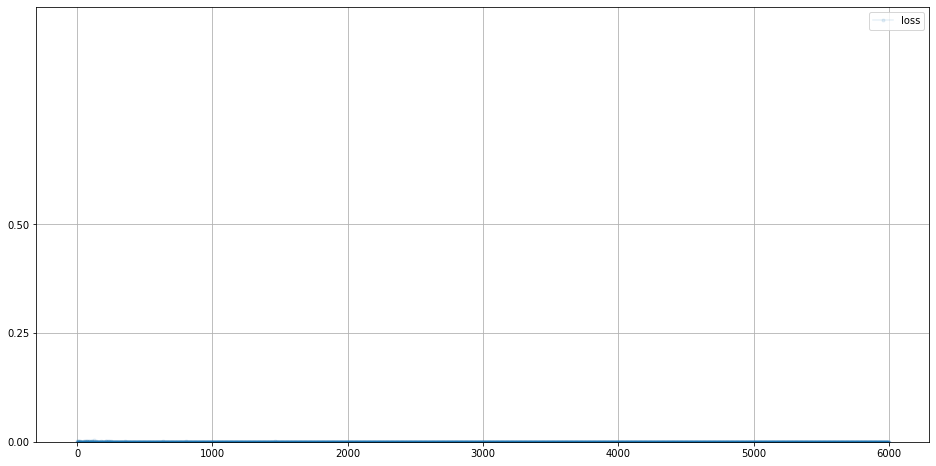

In [40]:
plot_progress(progress)

In [41]:
model(torch.rand(784, device=device))

tensor([0.0017], device='cuda:0', grad_fn=<SigmoidBackward>)

In [42]:
class Generator(nn.Module):

  def __init__(self):
    # constructor

    # instantiate parent class
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(1,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,784),
        nn.Sigmoid()
    )


  def forward(self, input):
    # forward pass  
    return self.model(input)

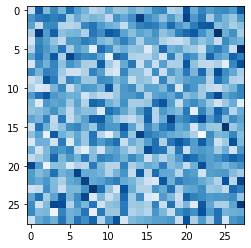

In [45]:
G = Generator()

sample = torch.rand([1])
output = G(sample)
img = output.detach().cpu().numpy().reshape(28,28)
plt.imshow(img, interpolation="none", cmap="Blues")

In [72]:
def train_generator(D, G, criterion, d_optim, g_optim, epochs):

  counter = 0
  d_progress = []
  g_progress = []

  for epoch in range(epochs):

    for label, inputs, target in train_ds:

      counter += 1

      # STEP 1
      # train discriminator on real
      inputs = inputs.to(device)
      outputs = D(inputs)
      
      real = torch.tensor([1.0], dtype=torch.float, device = device) 
      loss = criterion(outputs, real)

      # update discriminator weights
      d_optim.zero_grad()
      loss.backward()
      d_optim.step()

      # STEP 2
      # train discriminator on generated image
      noise = torch.rand(1, device=device)
      inputs = G(noise).detach()

      outputs = D(inputs)

      fake = torch.tensor([0.0], dtype=torch.float, device=device)
      loss = criterion(outputs, fake)

      # update discriminator weights
      d_optim.zero_grad()
      loss.backward()
      d_optim.step()

      if counter % 10 == 0:
        d_progress.append(loss.item())

      # STEP 3
      # train generator
      noise = torch.rand(1, device=device)
      inputs = G(noise)
      outputs = D(inputs)

      loss = criterion(outputs, real)

      # update generator weights
      g_optim.zero_grad()
      loss.backward()
      g_optim.step()

      if counter % 10 == 0:
        g_progress.append(loss.item())

      if counter % 10000 == 0:
        print(f"iter: {counter:10}," +
              f"D loss: {d_progress[-1]:8.6f}," +
              f"G loss: {g_progress[-1]:8.6f}")

      # early stopping    
      if counter > 10000 and d_progress[-1] > 0.8:
        break
        
  return D, G, d_progress, g_progress

In [51]:
G = Generator()
G = G.to(device)

D = Discriminator()
D = D.to(device)

criterion = nn.MSELoss()

d_optim = torch.optim.Adam(D.parameters())
g_optim = torch.optim.Adam(G.parameters())

epochs = 3

params = {
    "D" : D,
    "G" : G,
    "criterion" : criterion,
    "d_optim" : d_optim,
    "g_optim" : g_optim,
    "epochs" : epochs
}

In [60]:
D, G, d_progress, g_progress = train_generator(**params)

iter:       1000,D loss: 0.000012,G loss: 0.994573
iter:       2000,D loss: 0.000005,G loss: 0.995976
iter:       3000,D loss: 0.002081,G loss: 0.927211
iter:       4000,D loss: 0.000041,G loss: 0.983799
iter:       5000,D loss: 0.000004,G loss: 0.999623
iter:       6000,D loss: 0.000131,G loss: 0.984455
iter:       7000,D loss: 0.000004,G loss: 0.996371
iter:       8000,D loss: 0.000026,G loss: 0.989995
iter:       9000,D loss: 0.000001,G loss: 0.997692
iter:      10000,D loss: 0.000009,G loss: 0.994409
iter:      11000,D loss: 0.000031,G loss: 0.989708
iter:      12000,D loss: 0.000132,G loss: 0.978680
iter:      13000,D loss: 0.000000,G loss: 0.999932
iter:      14000,D loss: 0.000000,G loss: 0.999922
iter:      15000,D loss: 0.000000,G loss: 0.999940
iter:      16000,D loss: 0.000001,G loss: 0.998589
iter:      17000,D loss: 0.000000,G loss: 0.999499
iter:      18000,D loss: 0.000000,G loss: 0.999801
iter:      19000,D loss: 0.000000,G loss: 1.000000
iter:      20000,D loss: 0.0000

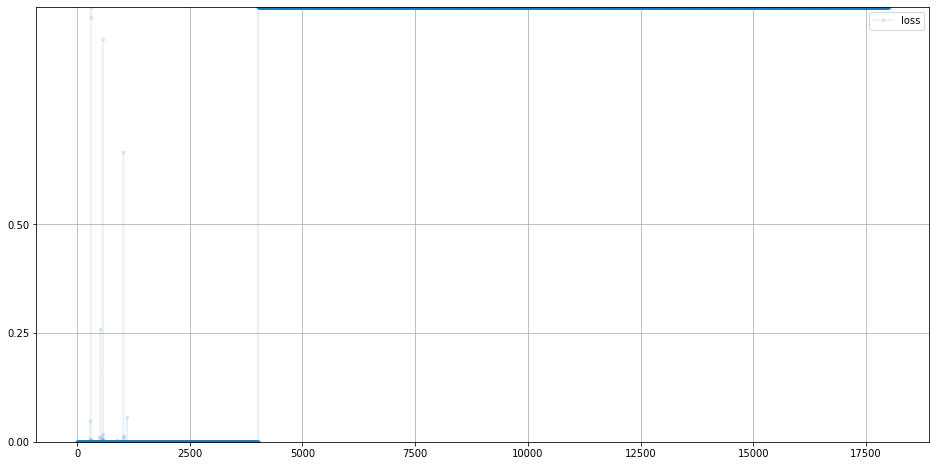

In [61]:
plot_progress(d_progress)

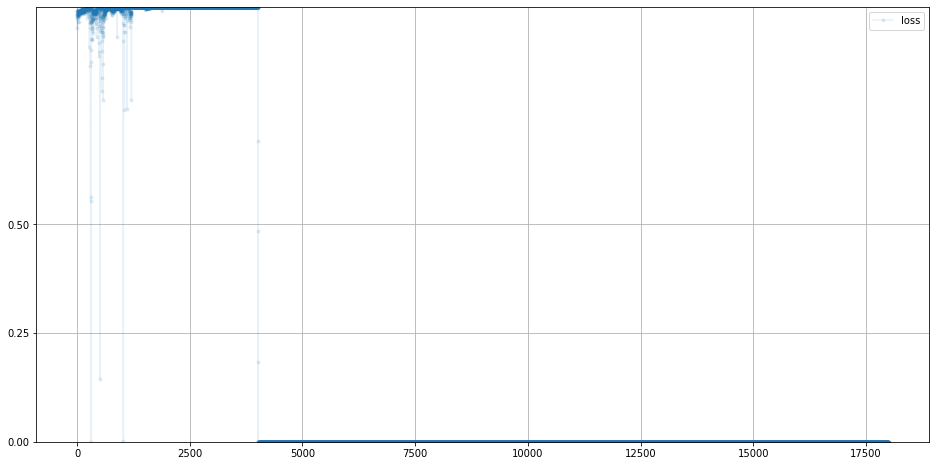

In [62]:
plot_progress(g_progress)

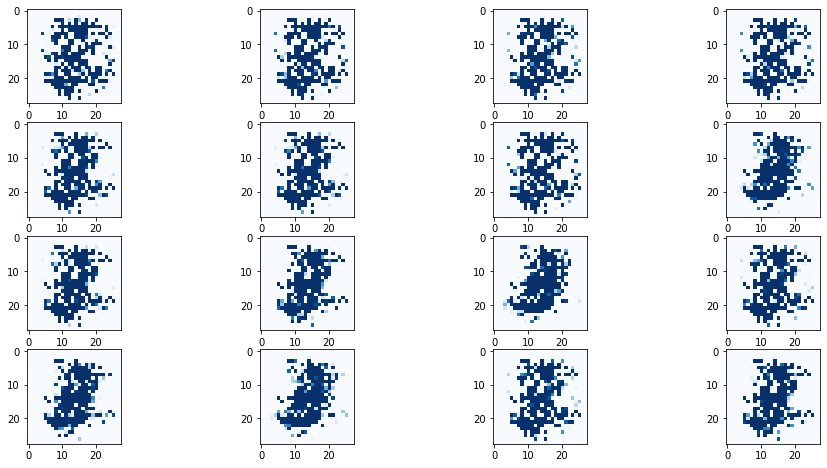

In [70]:
f, axarr = plt.subplots(nrows=4, ncols=4, figsize=(16,8))
for i in range(4):
  for j in range(4):
    output = G.forward(torch.rand(1, device=device))
    img = output.detach().cpu().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation="none", cmap="Blues")
    pass
  pass

This is called Mode Colapse. When GAN is producing similar image over and over again. 

In [68]:
D(torch.rand(784))

tensor([5.2479e-06], grad_fn=<SigmoidBackward>)

In our case generator outperforms discriminator, but generates similar images without definite shape.

### Improving generator

- increase size of inputs features from 1 to 100
- normalize the input noise. Before - uniform dist 0 to 1, now normal distribution

In [73]:
class Generator(nn.Module):

  def __init__(self):
    super().__init__()

    self.model = nn.Sequential(
        nn.Linear(100,200),
        nn.LeakyReLU(0.02),
        nn.LayerNorm(200),
        nn.Linear(200,784),
        nn.Sigmoid()
    )

  def forward(self, inputs):
    return self.model(inputs)

In [85]:
def train_generator(D, G, criterion, d_optim, g_optim, epochs):

  counter = 0
  d_progress = []
  g_progress = []

  for epoch in range(epochs):

    for label, inputs, target in train_ds:

      counter += 1

      # STEP 1
      # train discriminator on real
      inputs = inputs.to(device)
      outputs = D(inputs)
      
      real = torch.tensor([1.0], dtype=torch.float, device = device) 
      loss = criterion(outputs, real)

      # update discriminator weights
      d_optim.zero_grad()
      loss.backward()
      d_optim.step()

      # STEP 2
      # train discriminator on generated image

      #####################
      #.       NEW.       #
      #####################
      seed = torch.randn(100, device=device) # normal dist
      inputs = G(seed).detach()

      outputs = D(inputs)

      fake = torch.tensor([0.0], dtype=torch.float, device=device)
      loss = criterion(outputs, fake)

      # update discriminator weights
      d_optim.zero_grad()
      loss.backward()
      d_optim.step()

      if counter % 10 == 0:
        d_progress.append(loss.item())

      # STEP 3
      # train generator

      #####################
      #.       NEW.       #
      #####################
      seed = torch.randn(100, device=device) # normal dist
      inputs = G(seed)
      outputs = D(inputs)

      loss = criterion(outputs, real)

      # update generator weights
      g_optim.zero_grad()
      loss.backward()
      g_optim.step()

      if counter % 10 == 0:
        g_progress.append(loss.item())

      if counter % 1000 == 0:
        print(f"iter: {counter:8}, " +
              f"D loss: {d_progress[-1]:8.6f}, " +
              f"G loss: {g_progress[-1]:8.6f}")

      # early stopping    
      if epoch > 2 and d_progress[-1] > 0.99:
        break
        
  return D, G, d_progress, g_progress

In [86]:
G = Generator()
G = G.to(device)

D = Discriminator()
D = D.to(device)

criterion = nn.BCELoss()

g_optim = torch.optim.Adam(G.parameters(), lr=0.0001)
d_optim = torch.optim.Adam(D.parameters(), lr=0.0001)

epochs = 4

params = {
    "D" : D,
    "G" : G,
    "criterion" : criterion,
    "d_optim" : d_optim,
    "g_optim" : g_optim,
    "epochs" : epochs
}

In [87]:
D, G, d_progress, g_progress = train_generator(**params)

iter:     1000, D loss: 0.000283, G loss: 8.145088
iter:     2000, D loss: 0.000310, G loss: 4.874806
iter:     3000, D loss: 0.022025, G loss: 3.961811
iter:     4000, D loss: 0.017766, G loss: 3.554852
iter:     5000, D loss: 0.022812, G loss: 4.050885
iter:     6000, D loss: 0.010909, G loss: 4.263762
iter:     7000, D loss: 0.110287, G loss: 2.996713
iter:     8000, D loss: 0.012084, G loss: 5.044606
iter:     9000, D loss: 0.006200, G loss: 4.937600
iter:    10000, D loss: 0.002304, G loss: 6.250927
iter:    11000, D loss: 0.001254, G loss: 5.984696
iter:    12000, D loss: 0.003402, G loss: 3.119179
iter:    13000, D loss: 0.026512, G loss: 3.989574
iter:    14000, D loss: 0.002277, G loss: 1.187912
iter:    15000, D loss: 0.008855, G loss: 4.773542
iter:    16000, D loss: 0.451981, G loss: 0.747234
iter:    17000, D loss: 2.105039, G loss: 3.132871
iter:    18000, D loss: 0.017090, G loss: 4.321963
iter:    19000, D loss: 0.005912, G loss: 5.372669
iter:    20000, D loss: 0.00203

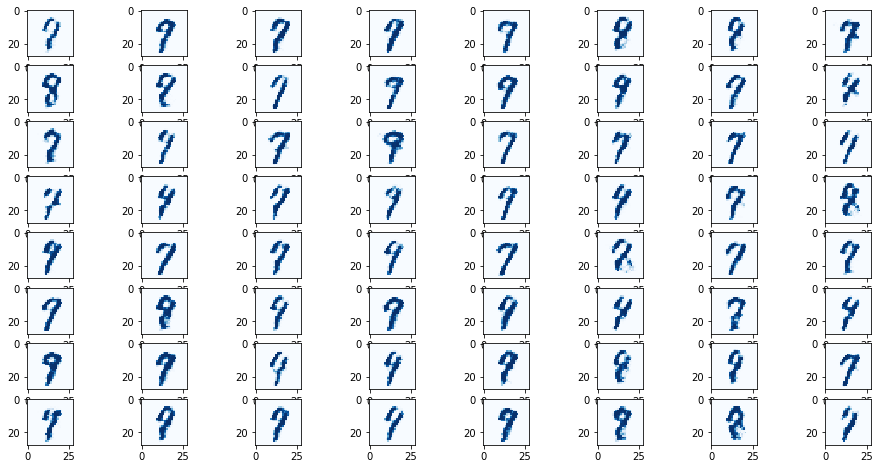

In [89]:
f, axarr = plt.subplots(nrows=8, ncols=8, figsize=(16,8))
for i in range(8):
  for j in range(8):
    output = G.forward(torch.rand(100, device=device))
    img = output.detach().cpu().numpy().reshape(28,28)
    axarr[i,j].imshow(img, interpolation="none", cmap="Blues")
    pass
  pass